# Notebook 01: Data Exploration and Processing

## Pancreas CT Segmentation using TransUNet

This notebook covers:
1. Environment setup and library installation
2. Downloading MSD Task07 Pancreas dataset
3. Data splitting (Train/Val/Test)
4. MONAI transformation pipeline
5. Visualization utilities
6. Sanity check with sample data

## 1. Environment Setup

In [1]:
# Import standard libraries
import os
import sys
import json
import random
from pathlib import Path

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt

# Medical imaging
import nibabel as nib
from tqdm import tqdm

# MONAI for medical image processing
import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    EnsureTyped,
)

# Print MONAI configuration
print_config()

MONAI version: 1.5.2
Numpy version: 2.4.1
Pytorch version: 2.7.0.dev20250310+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d18565fb3e4fd8c556707f91ac280a2dc3f681c1
MONAI __file__: c:\Users\<username>\Desktop\Đồ Án Tốt Nghiệp\.venv\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.3
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 12.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.22.0.dev20250226+cu124
tqdm version: 4.67.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.2.2
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNK

In [4]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Project paths (notebook is in notebooks/ folder, so go up one level)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

# Create directories
DATA_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Project root: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp
Data directory: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\data
Output directory: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\outputs


## 2. Load MSD Task07 Pancreas Dataset

The Medical Segmentation Decathlon (MSD) Task07 Pancreas dataset contains:
- 420 portal venous phase CT scans
- Labels for pancreas and pancreatic tumors
- Source: Memorial Sloan Kettering Cancer Center

> **Note**: Dataset should be downloaded beforehand using:
> ```bash
> python scripts/download_dataset.py --output ./data
> ```

In [5]:
# Dataset path (downloaded via scripts/download_dataset.py)
DATASET_DIR = DATA_DIR / "Task07_Pancreas"

# Verify dataset exists
if DATASET_DIR.exists():
    print(f"✓ Dataset found at: {DATASET_DIR}")
    
    # Quick verification
    images_tr = list((DATASET_DIR / "imagesTr").glob("*.nii.gz"))
    labels_tr = list((DATASET_DIR / "labelsTr").glob("*.nii.gz"))
    images_ts = list((DATASET_DIR / "imagesTs").glob("*.nii.gz"))
    
    print(f"  - Training images: {len(images_tr)}")
    print(f"  - Training labels: {len(labels_tr)}")
    print(f"  - Test images: {len(images_ts)}")
else:
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_DIR}\n"
        "Please download the dataset first using:\n"
        "  python scripts/download_dataset.py --output ./data"
    )

✓ Dataset found at: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\data\Task07_Pancreas
  - Training images: 283
  - Training labels: 282
  - Test images: 146


In [6]:
# Explore dataset structure
print("Dataset structure:")
for item in DATASET_DIR.iterdir():
    if item.is_dir():
        files = list(item.glob("*"))
        print(f"  {item.name}/: {len(files)} files")
    else:
        print(f"  {item.name}")

Dataset structure:
  .DS_Store
  ._.DS_Store
  ._dataset.json
  ._imagesTr
  ._imagesTs
  ._labelsTr
  dataset.json
  imagesTr/: 285 files
  imagesTs/: 146 files
  labelsTr/: 284 files


In [7]:
# Load dataset.json for metadata
dataset_json_path = DATASET_DIR / "dataset.json"

with open(dataset_json_path, "r") as f:
    dataset_info = json.load(f)

print("Dataset Information:")
print(f"  Name: {dataset_info.get('name', 'N/A')}")
print(f"  Description: {dataset_info.get('description', 'N/A')}")
print(f"  Modality: {dataset_info.get('modality', 'N/A')}")
print(f"  Labels: {dataset_info.get('labels', 'N/A')}")
print(f"  Number of training samples: {dataset_info.get('numTraining', 'N/A')}")
print(f"  Number of test samples: {dataset_info.get('numTest', 'N/A')}")

Dataset Information:
  Name: Pancreas
  Description: Pancreas and cancer segmentation
  Modality: {'0': 'CT'}
  Labels: {'0': 'background', '1': 'pancreas', '2': 'cancer'}
  Number of training samples: 281
  Number of test samples: 139


## 3. Data Splitting

Split the training data into:
- Train: 80%
- Validation: 10%
- Test: 10%

In [8]:
def create_data_splits(dataset_dir, train_ratio=0.8, val_ratio=0.1, seed=42):
    """
    Split dataset into train, validation, and test sets.
    
    Args:
        dataset_dir: Path to Task07_Pancreas directory
        train_ratio: Proportion for training (default: 0.8)
        val_ratio: Proportion for validation (default: 0.1)
        seed: Random seed for reproducibility
        
    Returns:
        Dictionary with train, val, test lists
    """
    dataset_dir = Path(dataset_dir)
    
    # Get all training images
    images_dir = dataset_dir / "imagesTr"
    labels_dir = dataset_dir / "labelsTr"
    
    image_files = sorted(images_dir.glob("*.nii.gz"))
    
    # Create data dictionaries
    data_dicts = []
    for img_path in image_files:
        # Label filename: pancreas_XXX.nii.gz (image is pancreas_XXX_0000.nii.gz)
        label_name = img_path.name.replace("_0000", "")
        label_path = labels_dir / label_name
        
        if label_path.exists():
            data_dicts.append({
                "image": str(img_path),
                "label": str(label_path),
            })
    
    print(f"Total samples with labels: {len(data_dicts)}")
    
    # Shuffle and split
    random.seed(seed)
    random.shuffle(data_dicts)
    
    n_total = len(data_dicts)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_data = data_dicts[:n_train]
    val_data = data_dicts[n_train:n_train + n_val]
    test_data = data_dicts[n_train + n_val:]
    
    splits = {
        "train": train_data,
        "val": val_data,
        "test": test_data,
    }
    
    print(f"Train: {len(train_data)} samples")
    print(f"Val: {len(val_data)} samples")
    print(f"Test: {len(test_data)} samples")
    
    return splits

In [9]:
# Create splits
data_splits = create_data_splits(DATASET_DIR, seed=SEED)

# Save splits to JSON
splits_path = OUTPUT_DIR / "data_splits.json"
with open(splits_path, "w") as f:
    json.dump(data_splits, f, indent=2)

print(f"\nData splits saved to: {splits_path}")

Total samples with labels: 282
Train: 225 samples
Val: 28 samples
Test: 29 samples

Data splits saved to: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\outputs\data_splits.json


## 4. MONAI Transformation Pipeline

Define preprocessing transforms:
1. LoadImage: Load NIfTI files
2. EnsureChannelFirst: Add channel dimension
3. Orientation (RAS): Standardize orientation
4. Spacing: Resample to 1.0mm isotropic
5. ScaleIntensityRanged: HU windowing [-175, 250]
6. CropForeground: Remove empty background

In [10]:
# Define preprocessing transforms
preprocessing_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-175,  # HU minimum (soft tissue window)
        a_max=250,   # HU maximum
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

print("Preprocessing pipeline defined:")
for i, t in enumerate(preprocessing_transforms.transforms):
    print(f"  {i+1}. {t.__class__.__name__}")

Preprocessing pipeline defined:
  1. LoadImaged
  2. EnsureChannelFirstd
  3. Orientationd
  4. Spacingd
  5. ScaleIntensityRanged
  6. CropForegroundd
  7. EnsureTyped


c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\.venv\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## 5. Visualization Utilities

In [11]:
def show_slices(image, label=None, title="CT Slices", figsize=(15, 5)):
    """
    Display axial, coronal, and sagittal slices of a 3D volume.
    
    Args:
        image: 3D numpy array (D, H, W) or (C, D, H, W)
        label: Optional 3D numpy array with same shape
        title: Figure title
        figsize: Figure size
    """
    # Handle channel dimension
    if image.ndim == 4:
        image = image[0]
    if label is not None and label.ndim == 4:
        label = label[0]
    
    # Convert to numpy if tensor
    if hasattr(image, 'numpy'):
        image = image.numpy()
    if label is not None and hasattr(label, 'numpy'):
        label = label.numpy()
    
    # Get center slices
    d, h, w = image.shape
    axial_idx = d // 2
    coronal_idx = h // 2
    sagittal_idx = w // 2
    
    # Find slice with maximum pancreas area for better visualization
    if label is not None:
        pancreas_area_per_slice = np.sum(label > 0, axis=(1, 2))
        if pancreas_area_per_slice.max() > 0:
            axial_idx = np.argmax(pancreas_area_per_slice)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Axial slice (top-down view)
    axes[0].imshow(image[axial_idx, :, :], cmap="gray")
    if label is not None:
        mask = np.ma.masked_where(label[axial_idx, :, :] == 0, label[axial_idx, :, :])
        axes[0].imshow(mask, cmap="jet", alpha=0.5, vmin=0, vmax=2)
    axes[0].set_title(f"Axial (slice {axial_idx}/{d})")
    axes[0].axis("off")
    
    # Coronal slice (front view)
    axes[1].imshow(image[:, coronal_idx, :], cmap="gray", aspect='auto')
    if label is not None:
        mask = np.ma.masked_where(label[:, coronal_idx, :] == 0, label[:, coronal_idx, :])
        axes[1].imshow(mask, cmap="jet", alpha=0.5, vmin=0, vmax=2, aspect='auto')
    axes[1].set_title(f"Coronal (slice {coronal_idx}/{h})")
    axes[1].axis("off")
    
    # Sagittal slice (side view)
    axes[2].imshow(image[:, :, sagittal_idx], cmap="gray", aspect='auto')
    if label is not None:
        mask = np.ma.masked_where(label[:, :, sagittal_idx] == 0, label[:, :, sagittal_idx])
        axes[2].imshow(mask, cmap="jet", alpha=0.5, vmin=0, vmax=2, aspect='auto')
    axes[2].set_title(f"Sagittal (slice {sagittal_idx}/{w})")
    axes[2].axis("off")
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [12]:
def analyze_volume(image, label):
    """
    Analyze volume statistics.
    
    Args:
        image: Image volume
        label: Label volume
    """
    # Handle channel dimension
    if image.ndim == 4:
        image = image[0]
    if label.ndim == 4:
        label = label[0]
    
    # Convert to numpy
    if hasattr(image, 'numpy'):
        image = image.numpy()
    if hasattr(label, 'numpy'):
        label = label.numpy()
    
    print("Volume Statistics:")
    print(f"  Image shape: {image.shape}")
    print(f"  Image dtype: {image.dtype}")
    print(f"  Image range: [{image.min():.3f}, {image.max():.3f}]")
    print(f"  Image mean: {image.mean():.3f}")
    print(f"  Image std: {image.std():.3f}")
    
    print(f"\n  Label shape: {label.shape}")
    print(f"  Label unique values: {np.unique(label)}")
    
    # Calculate class distribution
    total_voxels = label.size
    for cls in np.unique(label):
        count = np.sum(label == cls)
        percentage = 100 * count / total_voxels
        print(f"  Class {int(cls)}: {count:,} voxels ({percentage:.2f}%)")

## 6. Sanity Check: Load and Visualize Sample

In [13]:
# Load one sample from training set
sample_data = data_splits["train"][0]
print(f"Loading sample:")
print(f"  Image: {sample_data['image']}")
print(f"  Label: {sample_data['label']}")

Loading sample:
  Image: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\data\Task07_Pancreas\imagesTr\pancreas_101.nii.gz
  Label: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\data\Task07_Pancreas\labelsTr\pancreas_101.nii.gz


Raw Volume Info:
  Image shape: (512, 512, 98)
  Image voxel size: (np.float32(0.753906), np.float32(0.753906), np.float32(5.0))
  Image affine:
[[   0.75390601    0.            0.         -385.24597168]
 [   0.            0.75390601    0.         -385.24597168]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]


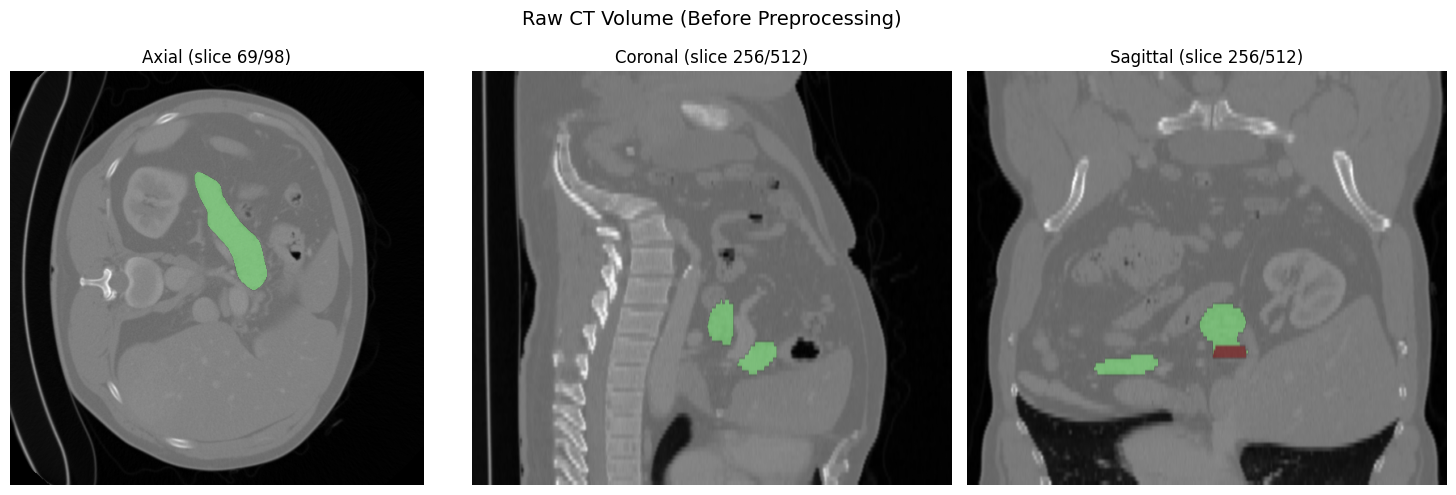

In [14]:
# Load raw volume (before preprocessing)
raw_image = nib.load(sample_data["image"])
raw_label = nib.load(sample_data["label"])

print("Raw Volume Info:")
print(f"  Image shape: {raw_image.shape}")
print(f"  Image voxel size: {raw_image.header.get_zooms()}")
print(f"  Image affine:\n{raw_image.affine}")

# Show raw slices
show_slices(
    raw_image.get_fdata().transpose(2, 0, 1),  # Reorder to (D, H, W)
    raw_label.get_fdata().transpose(2, 0, 1),
    title="Raw CT Volume (Before Preprocessing)"
)

In [15]:
# Apply preprocessing transforms
print("Applying preprocessing transforms...")
processed_data = preprocessing_transforms(sample_data)

processed_image = processed_data["image"]
processed_label = processed_data["label"]

print("\nProcessed Volume:")
analyze_volume(processed_image, processed_label)

Applying preprocessing transforms...

Processed Volume:
Volume Statistics:
  Image shape: (386, 331, 486)
  Image dtype: float32
  Image range: [0.000, 1.000]
  Image mean: 0.243
  Image std: 0.269

  Label shape: (386, 331, 486)

Processed Volume:
Volume Statistics:
  Image shape: (386, 331, 486)
  Image dtype: float32
  Image range: [0.000, 1.000]
  Image mean: 0.243
  Image std: 0.269

  Label shape: (386, 331, 486)
  Label unique values: [0. 1. 2.]
  Label unique values: [0. 1. 2.]
  Class 0: 61,950,096 voxels (99.77%)
  Class 1: 135,260 voxels (0.22%)
  Class 2: 8,920 voxels (0.01%)
  Class 0: 61,950,096 voxels (99.77%)
  Class 1: 135,260 voxels (0.22%)
  Class 2: 8,920 voxels (0.01%)


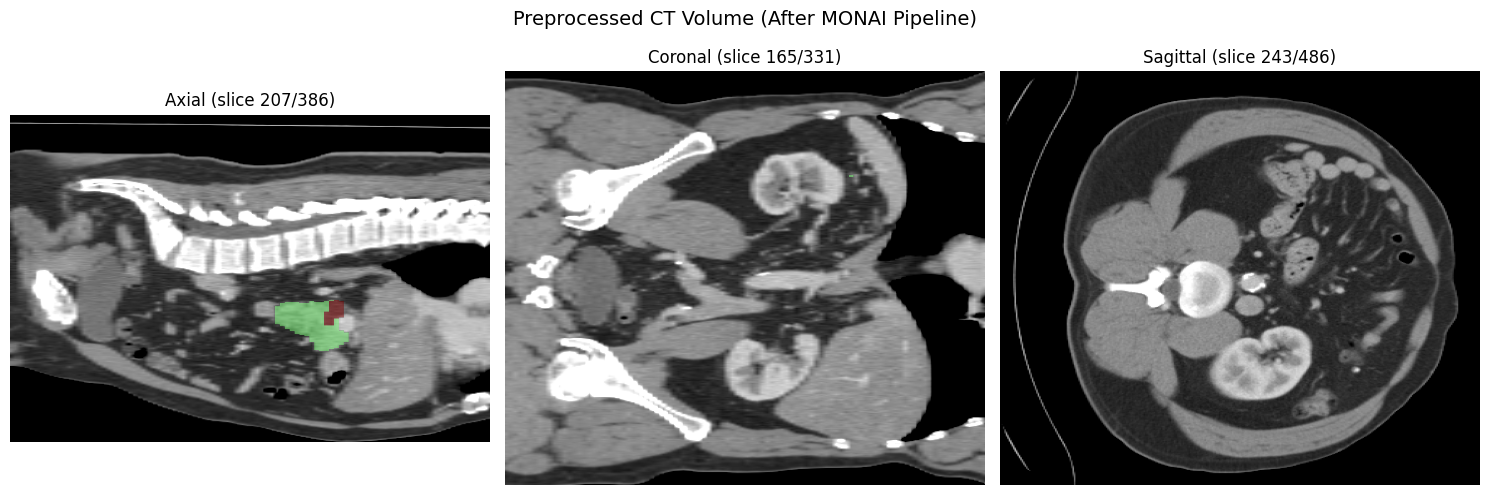

In [16]:
# Visualize preprocessed volume
show_slices(
    processed_image,
    processed_label,
    title="Preprocessed CT Volume (After MONAI Pipeline)"
)

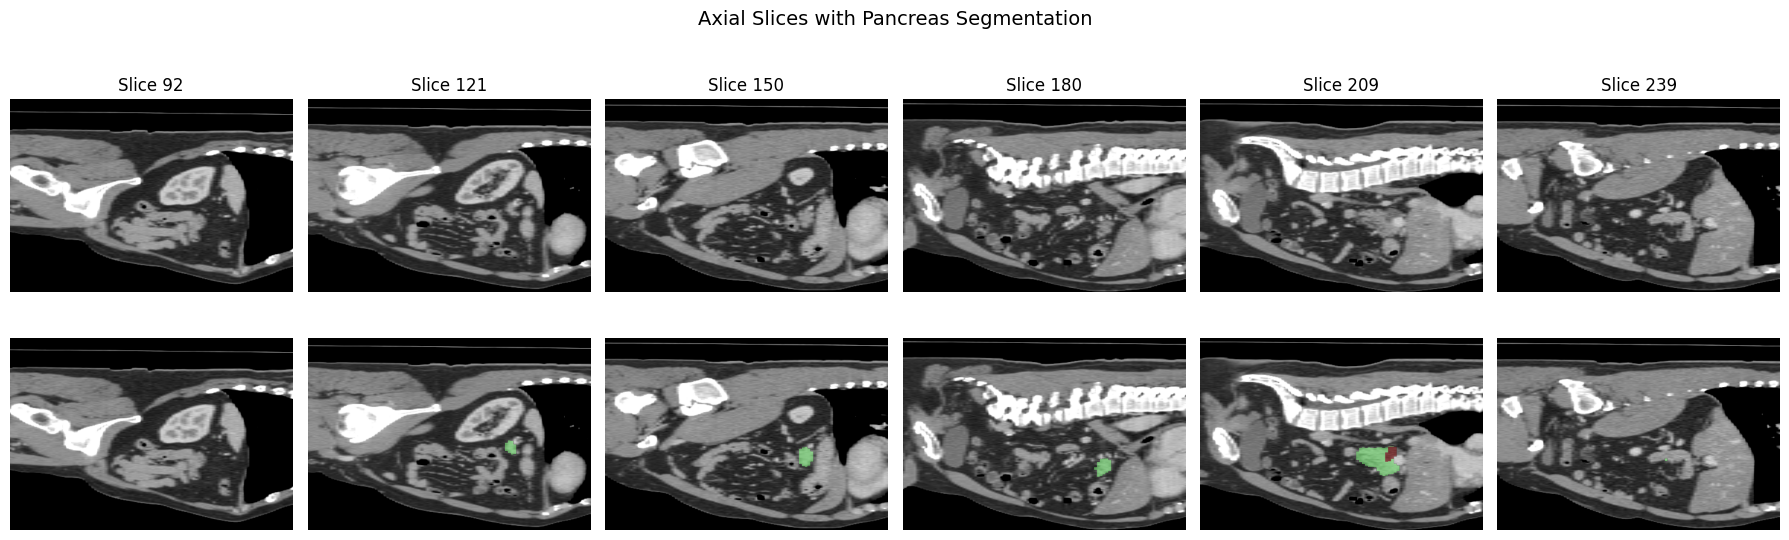

Total slices with pancreas: 148 / 386


In [17]:
# Show multiple axial slices with pancreas
def show_pancreas_slices(image, label, num_slices=6, figsize=(18, 6)):
    """
    Show multiple axial slices containing pancreas.
    """
    if image.ndim == 4:
        image = image[0]
    if label.ndim == 4:
        label = label[0]
    
    if hasattr(image, 'numpy'):
        image = image.numpy()
    if hasattr(label, 'numpy'):
        label = label.numpy()
    
    # Find slices with pancreas
    pancreas_slices = np.where(np.sum(label > 0, axis=(1, 2)) > 0)[0]
    
    if len(pancreas_slices) == 0:
        print("No pancreas slices found!")
        return
    
    # Select evenly spaced slices
    indices = np.linspace(0, len(pancreas_slices) - 1, num_slices, dtype=int)
    selected_slices = pancreas_slices[indices]
    
    fig, axes = plt.subplots(2, num_slices, figsize=figsize)
    
    for i, slice_idx in enumerate(selected_slices):
        # Top row: CT image
        axes[0, i].imshow(image[slice_idx], cmap="gray")
        axes[0, i].set_title(f"Slice {slice_idx}")
        axes[0, i].axis("off")
        
        # Bottom row: CT with mask overlay
        axes[1, i].imshow(image[slice_idx], cmap="gray")
        mask = np.ma.masked_where(label[slice_idx] == 0, label[slice_idx])
        axes[1, i].imshow(mask, cmap="jet", alpha=0.5, vmin=0, vmax=2)
        axes[1, i].axis("off")
    
    axes[0, 0].set_ylabel("CT Image", fontsize=12)
    axes[1, 0].set_ylabel("With Mask", fontsize=12)
    
    plt.suptitle("Axial Slices with Pancreas Segmentation", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"Total slices with pancreas: {len(pancreas_slices)} / {image.shape[0]}")

show_pancreas_slices(processed_image, processed_label)

## 7. Dataset Statistics Summary

In [18]:
# Analyze a subset of volumes to get statistics
def compute_dataset_statistics(data_list, transforms, num_samples=10):
    """
    Compute statistics across multiple volumes.
    """
    stats = {
        "shapes": [],
        "pancreas_volumes": [],
        "tumor_volumes": [],
        "pancreas_slice_counts": [],
    }
    
    num_samples = min(num_samples, len(data_list))
    
    for i in tqdm(range(num_samples), desc="Analyzing volumes"):
        data = transforms(data_list[i])
        image = data["image"].numpy() if hasattr(data["image"], 'numpy') else data["image"]
        label = data["label"].numpy() if hasattr(data["label"], 'numpy') else data["label"]
        
        if image.ndim == 4:
            image = image[0]
        if label.ndim == 4:
            label = label[0]
        
        stats["shapes"].append(image.shape)
        stats["pancreas_volumes"].append(np.sum(label == 1))
        stats["tumor_volumes"].append(np.sum(label == 2))
        stats["pancreas_slice_counts"].append(np.sum(np.any(label > 0, axis=(1, 2))))
    
    return stats

# Compute statistics
print("Computing dataset statistics...")
dataset_stats = compute_dataset_statistics(
    data_splits["train"][:10],
    preprocessing_transforms
)

Computing dataset statistics...


Analyzing volumes: 100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


In [19]:
# Print statistics
print("\nDataset Statistics (10 samples):")
print(f"\nVolume shapes:")
for i, shape in enumerate(dataset_stats["shapes"]):
    print(f"  Sample {i+1}: {shape}")

print(f"\nPancreas volume (voxels):")
print(f"  Mean: {np.mean(dataset_stats['pancreas_volumes']):,.0f}")
print(f"  Std: {np.std(dataset_stats['pancreas_volumes']):,.0f}")
print(f"  Min: {np.min(dataset_stats['pancreas_volumes']):,.0f}")
print(f"  Max: {np.max(dataset_stats['pancreas_volumes']):,.0f}")

print(f"\nSlices with pancreas:")
print(f"  Mean: {np.mean(dataset_stats['pancreas_slice_counts']):.1f}")
print(f"  Range: [{np.min(dataset_stats['pancreas_slice_counts'])}, {np.max(dataset_stats['pancreas_slice_counts'])}]")


Dataset Statistics (10 samples):

Volume shapes:
  Sample 1: (386, 331, 486)
  Sample 2: (382, 379, 246)
  Sample 3: (360, 274, 216)
  Sample 4: (366, 296, 211)
  Sample 5: (434, 363, 251)
  Sample 6: (454, 396, 260)
  Sample 7: (390, 325, 261)
  Sample 8: (316, 248, 216)
  Sample 9: (431, 378, 261)
  Sample 10: (363, 386, 126)

Pancreas volume (voxels):
  Mean: 96,976
  Std: 46,279
  Min: 51,255
  Max: 189,779

Slices with pancreas:
  Mean: 127.4
  Range: [88, 158]


## Summary

This notebook completed the following:

1. **Environment Setup**: Imported all necessary libraries (MONAI, nibabel, matplotlib)
2. **Data Download**: Downloaded MSD Task07 Pancreas dataset (~11.4GB compressed)
3. **Data Splitting**: Created 80/10/10 train/val/test splits saved to `outputs/data_splits.json`
4. **Transform Pipeline**: Defined MONAI preprocessing with:
   - Orientation standardization (RAS)
   - Isotropic resampling (1.0mm)
   - HU windowing [-175, 250]
   - Foreground cropping
5. **Visualization**: Created helper function to display 3-view slices with mask overlay
6. **Sanity Check**: Verified preprocessing on sample volume

Next: Notebook 02 - Model Architecture (TransUNet)